In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_2088162/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import os
os.chdir('../')
import torch
import pandas as pd
import numpy as np
import yaml
from sklearn import decomposition
from harmony import harmonize
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm
import utils.label_dict
from utils.label_dict import protein_to_num_full
from utils.label_dict import hierarchical_organization_single_cell_low_level, hierarchical_organization_single_cell_high_level
from utils.label_dict import hierarchical_organization_whole_image_low_level, hierarchical_organization_whole_image_high_level
from utils.analysis_utils import plot_UMAP, get_embeddings, create_cell_comparison, create_protein_hierarchy


### Create UMAPs

In [3]:
from sklearn.metrics import mutual_info_score

def create_bins(x):
    unique_xs = sorted(np.unique(x))
    bins = [unique_xs[0] - 0.5]
    for ind in range(len(unique_xs) - 1):
        bins.append(unique_xs[ind] + (unique_xs[ind + 1] - unique_xs[ind]) / 2)
    bins = bins + [unique_xs[-1] + 0.5]  
    return bins

def mutual_info(x,y,code_bin, factor_bin):
    c_xy = np.histogram2d(x,y,(code_bin, factor_bin))[0]
    mi = 0
    N = np.sum(c_xy)
    for i in range(c_xy.shape[0]):
        for j in range(c_xy.shape[1]):
            p_i = np.sum(c_xy[i,:]) / N
            p_j = np.sum(c_xy[:,j]) / N
            p_ij = c_xy[i,j] / N
            if p_ij == 0: 
                mi += 0 
            else:
                mi += (p_ij) * np.log(p_ij / (p_i * p_j))
    return mi

def conditional_mutual_info(x,y,z,bins):
    c_xyz = np.histogramdd((x, 
                          y, 
                          z),
                          bins)[0]
    N = np.sum(c_xyz)
    mi = 0
    p_z = c_xyz.sum(axis=(0,1)) / N
    p_iz = c_xyz.sum(axis=(1)) / N
    p_jz = c_xyz.sum(axis=(0)) / N
    p_ijzs = c_xyz / N
    N = np.sum(c_xyz)
    for i in (range(c_xyz.shape[0])):
        for j in range(c_xyz.shape[1]):
            for z in range(c_xyz.shape[2]):
                if p_ijzs[i,j,z] == 0: 
                    mi += 0 
                else:
                    mi += (p_ijzs[i,j,z]) * np.log((p_z[z] * p_ijzs[i,j,z]) / (p_iz[i,z] * p_jz[j,z]))
    return mi    


def MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def get_col_matrix(df, labels):
    if len(labels) == 1:
        values = df[labels[0]]
        unique_values = sorted(np.unique(values))
        mat = np.zeros((len(df), len(unique_values)))
        for ind, value in enumerate(unique_values):
            mat[np.where(values == value)[0], ind] = 1
        columns = unique_values
    else:
        mat = df[sorted(labels)].values.astype(int)
        columns = sorted(labels)
    return mat, columns

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


/scr/mdoron/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:501: RuntimeWarning: divide by zero encountered in power
  return func(xdata, *params) - ydata


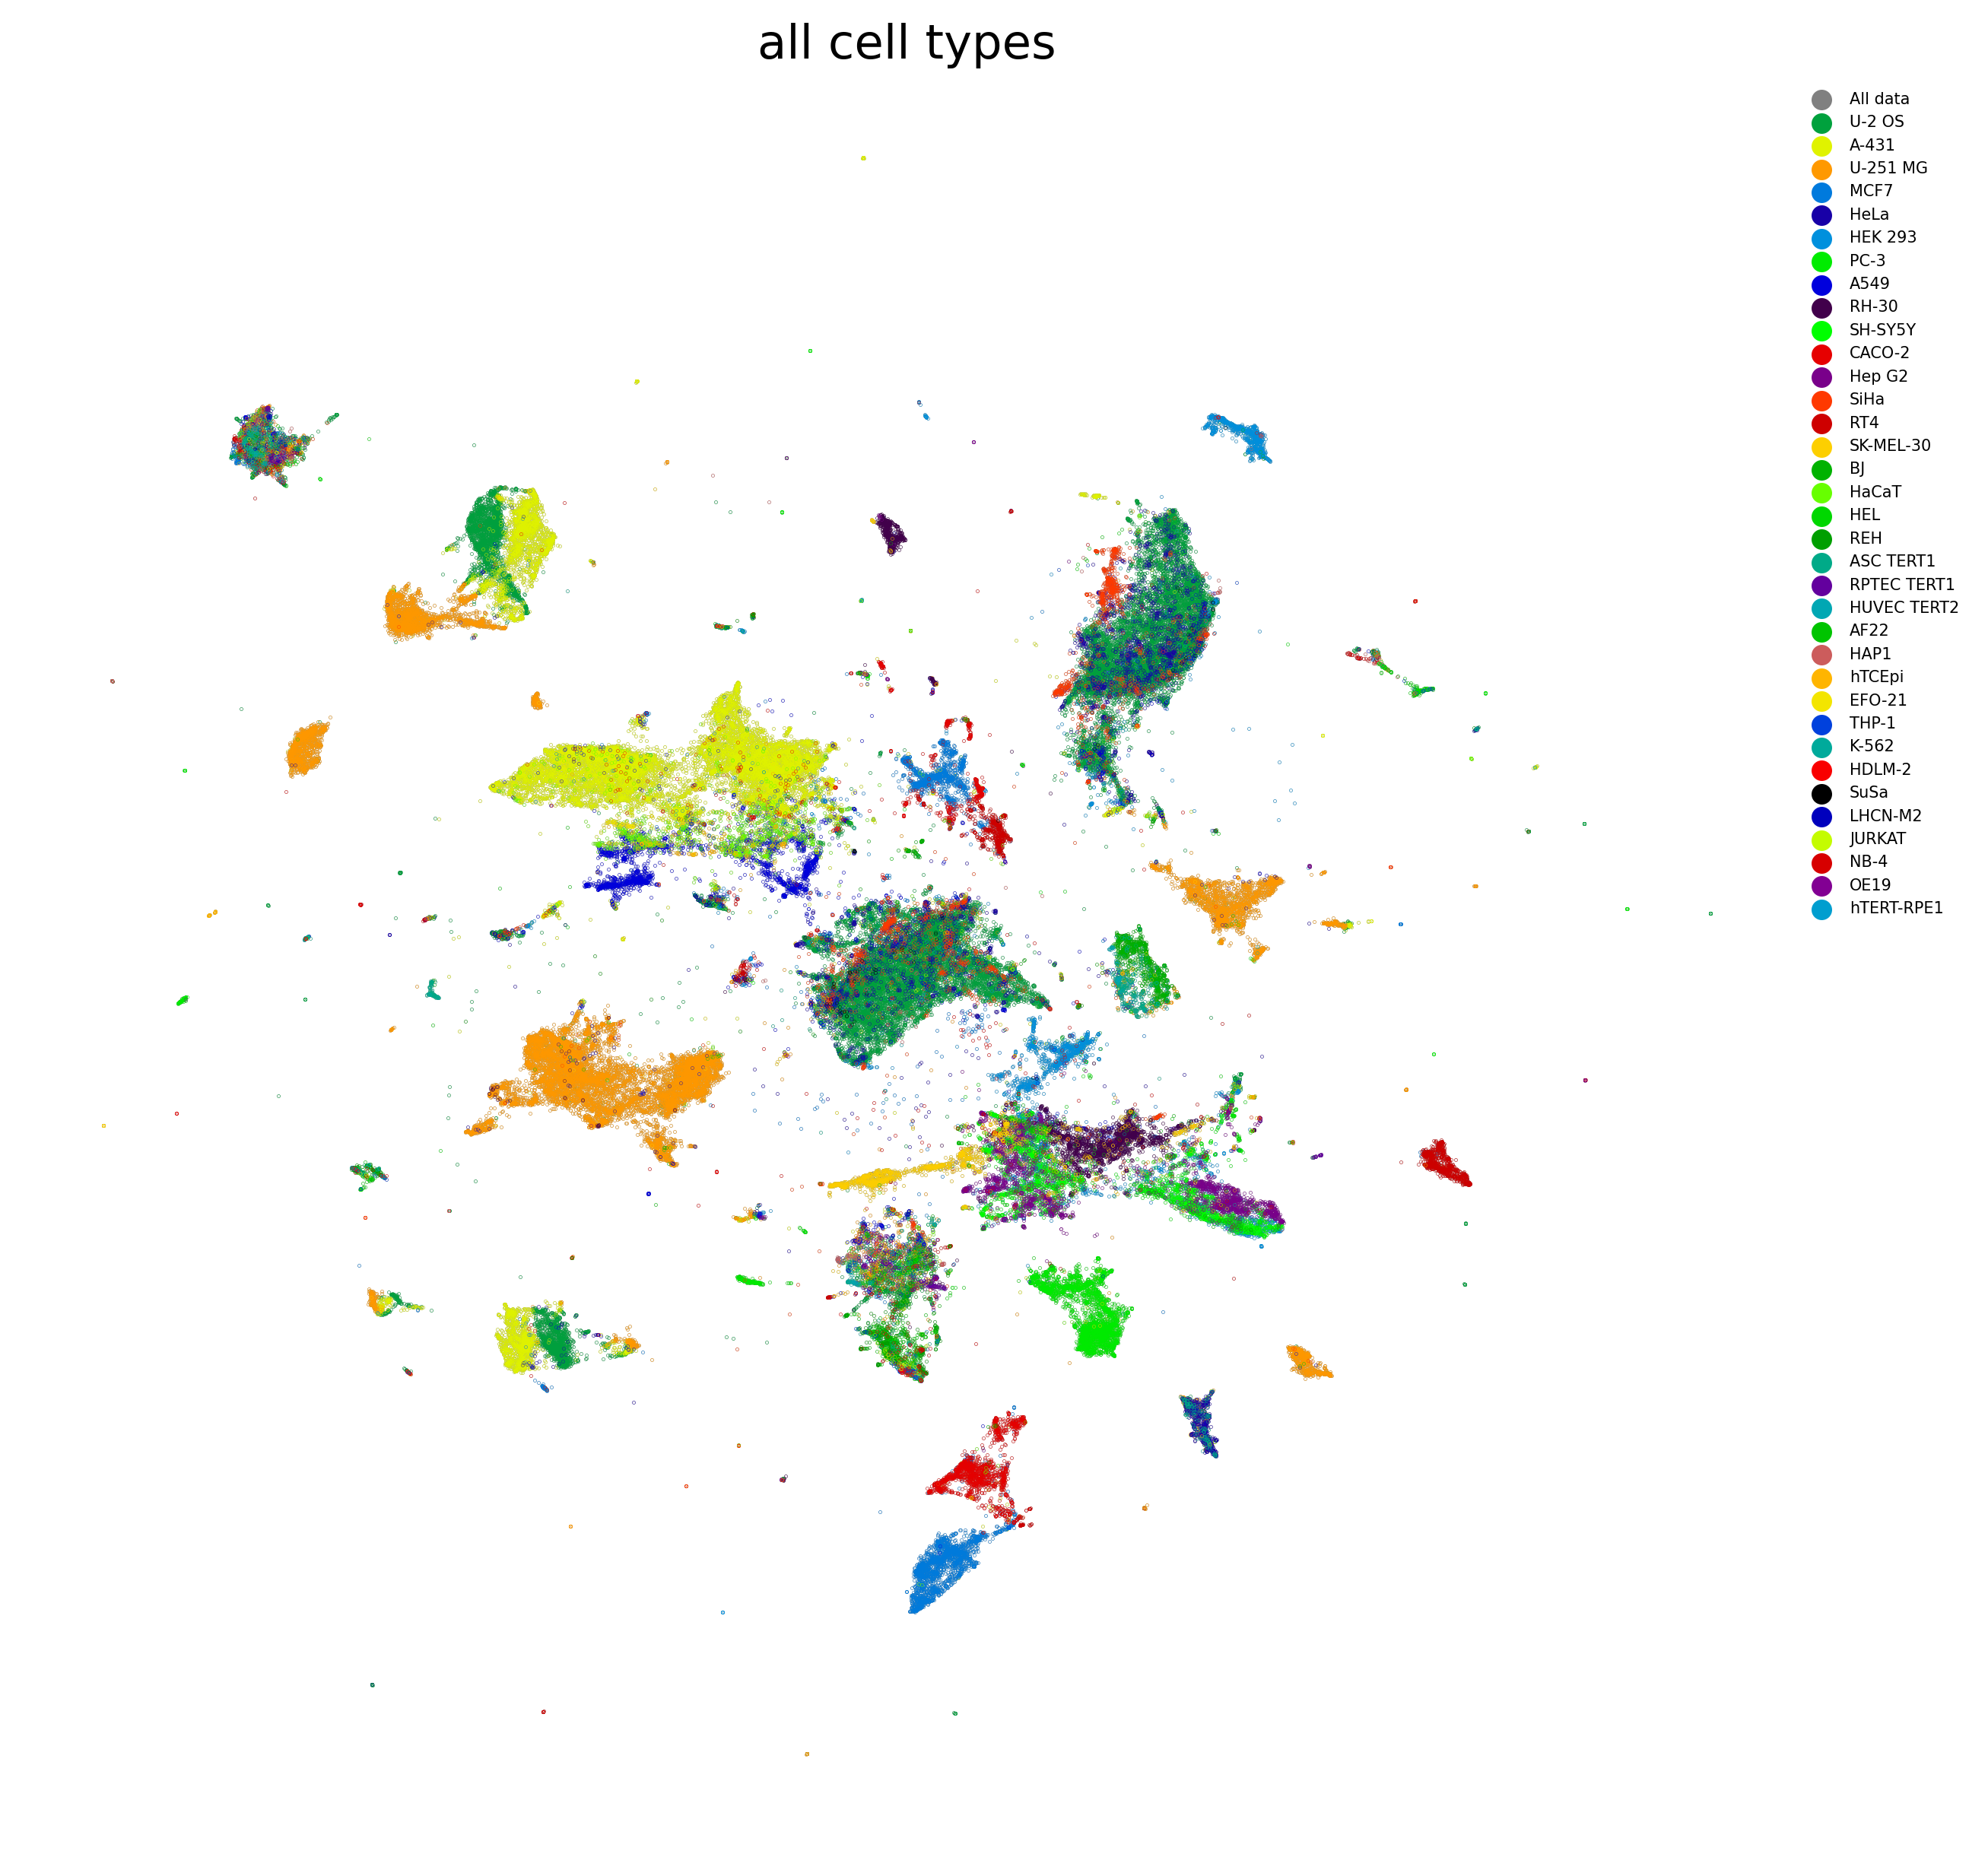

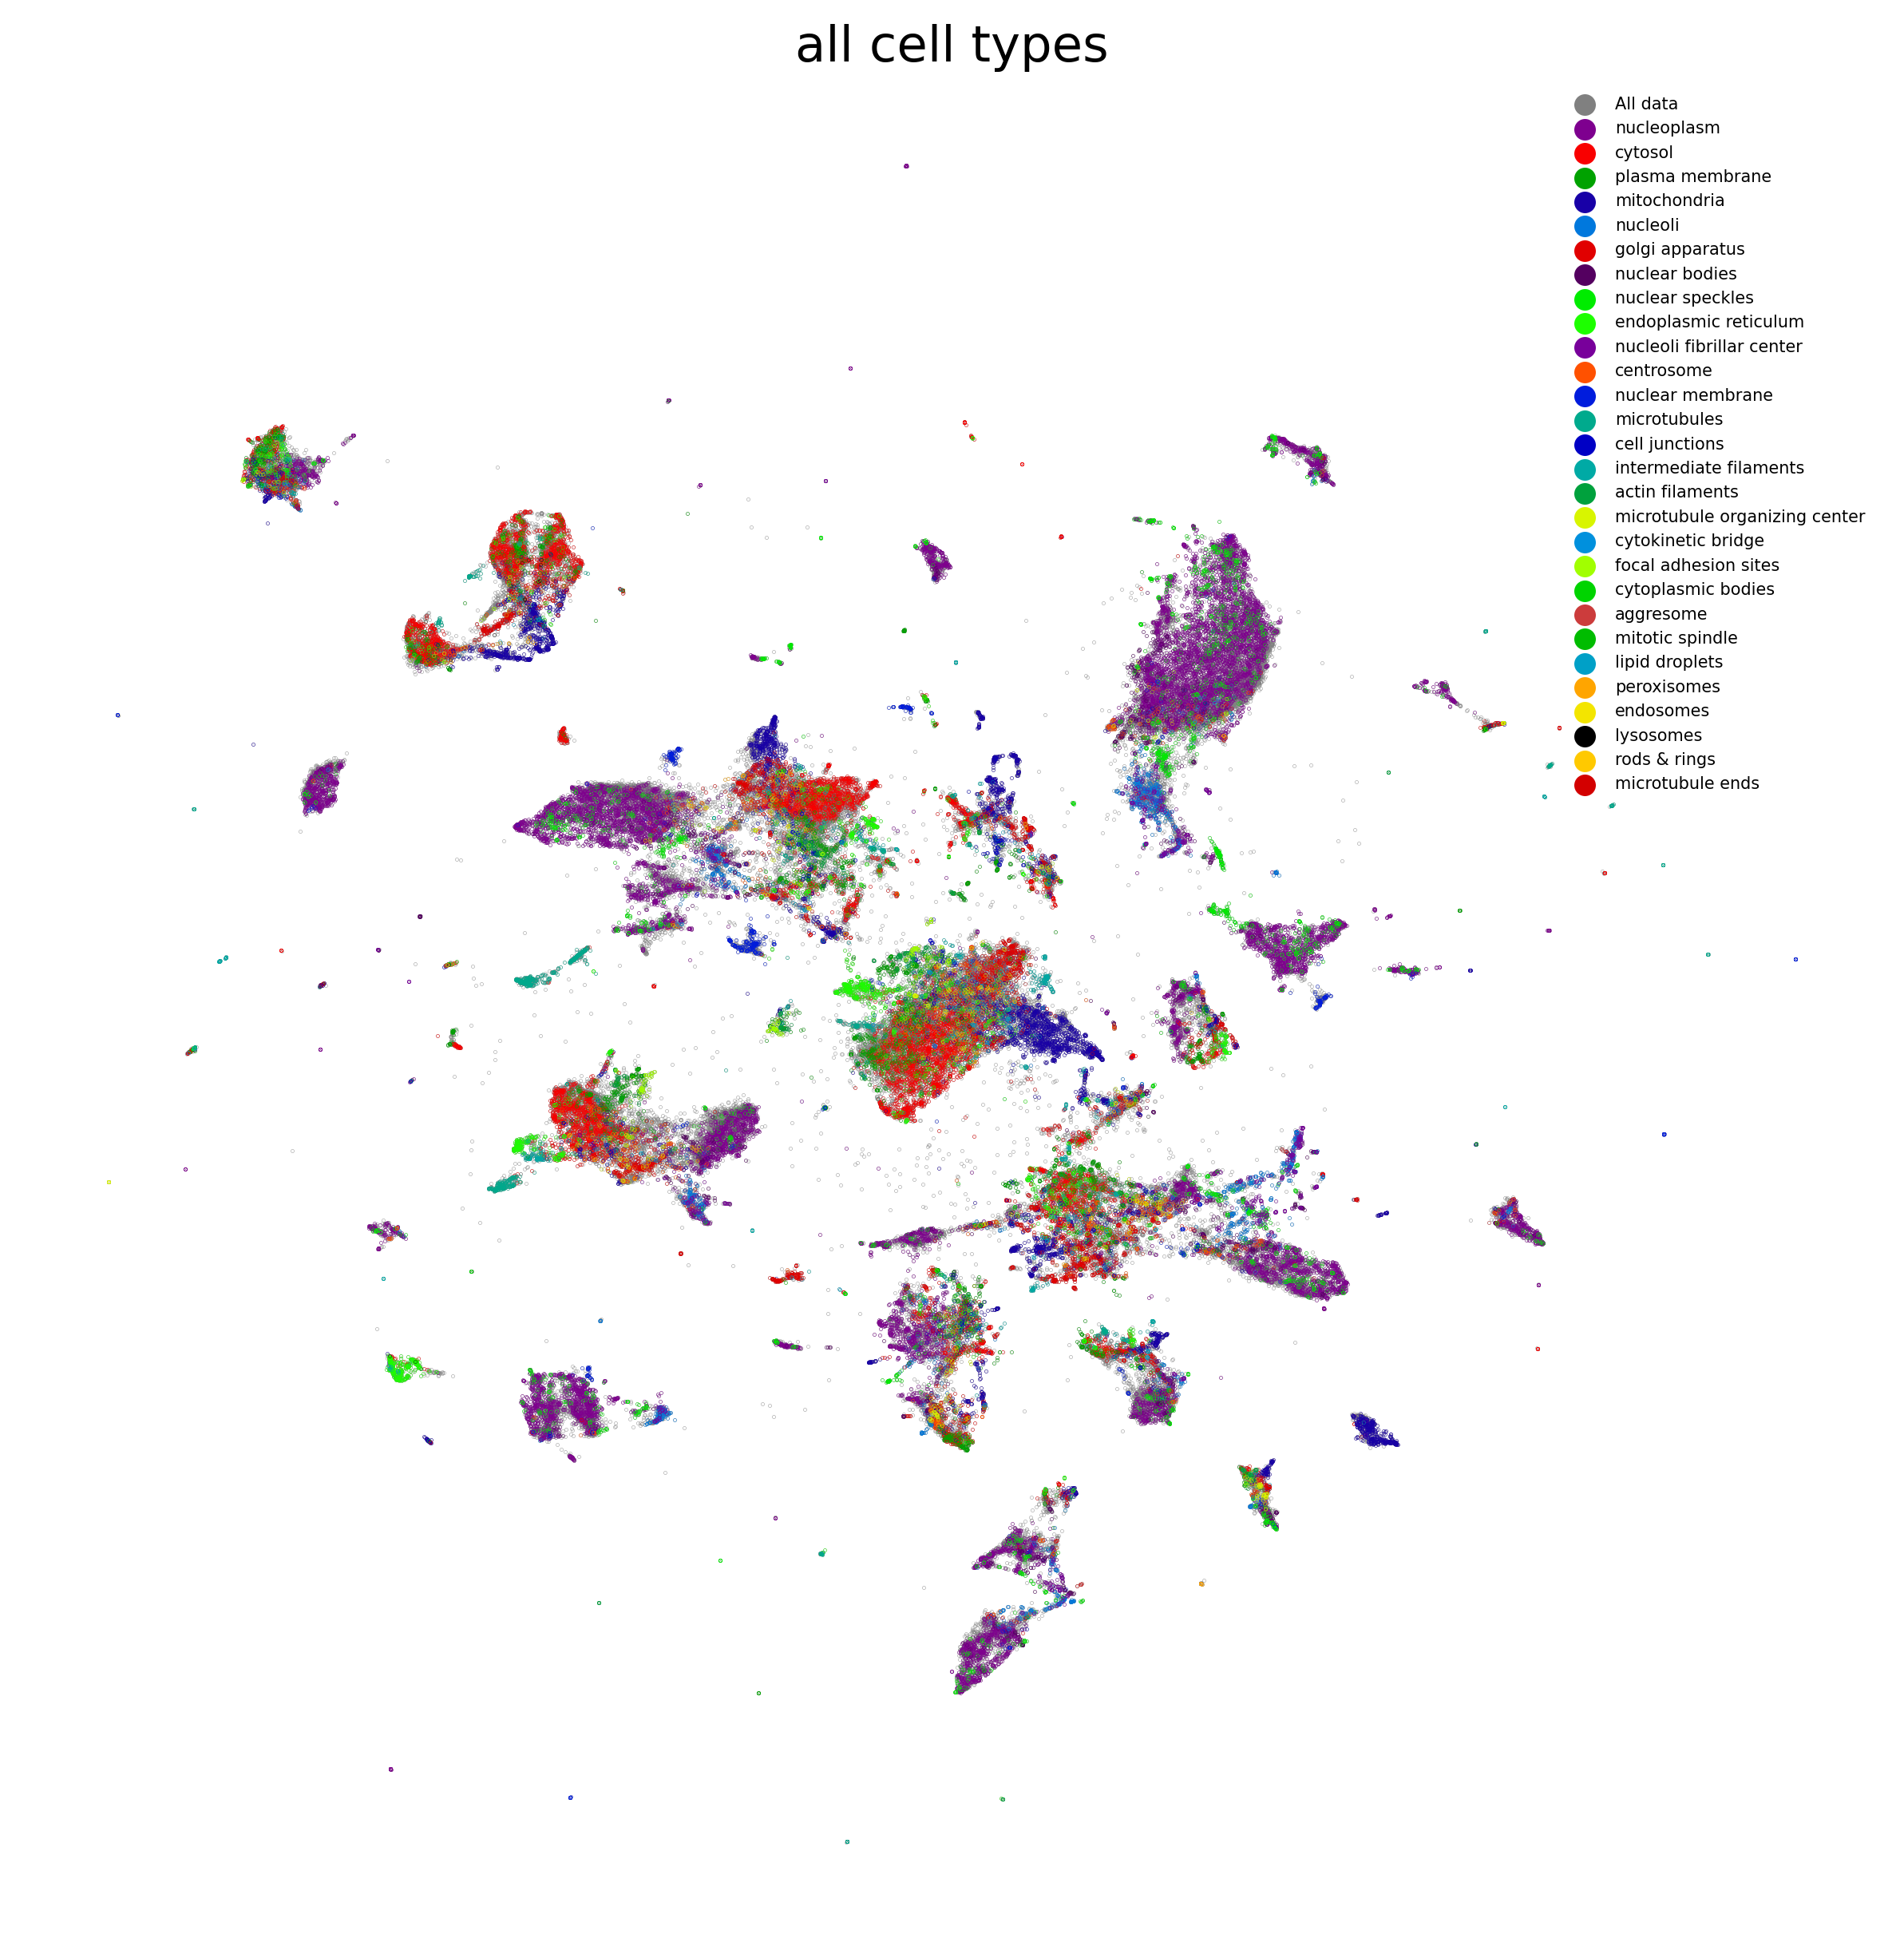

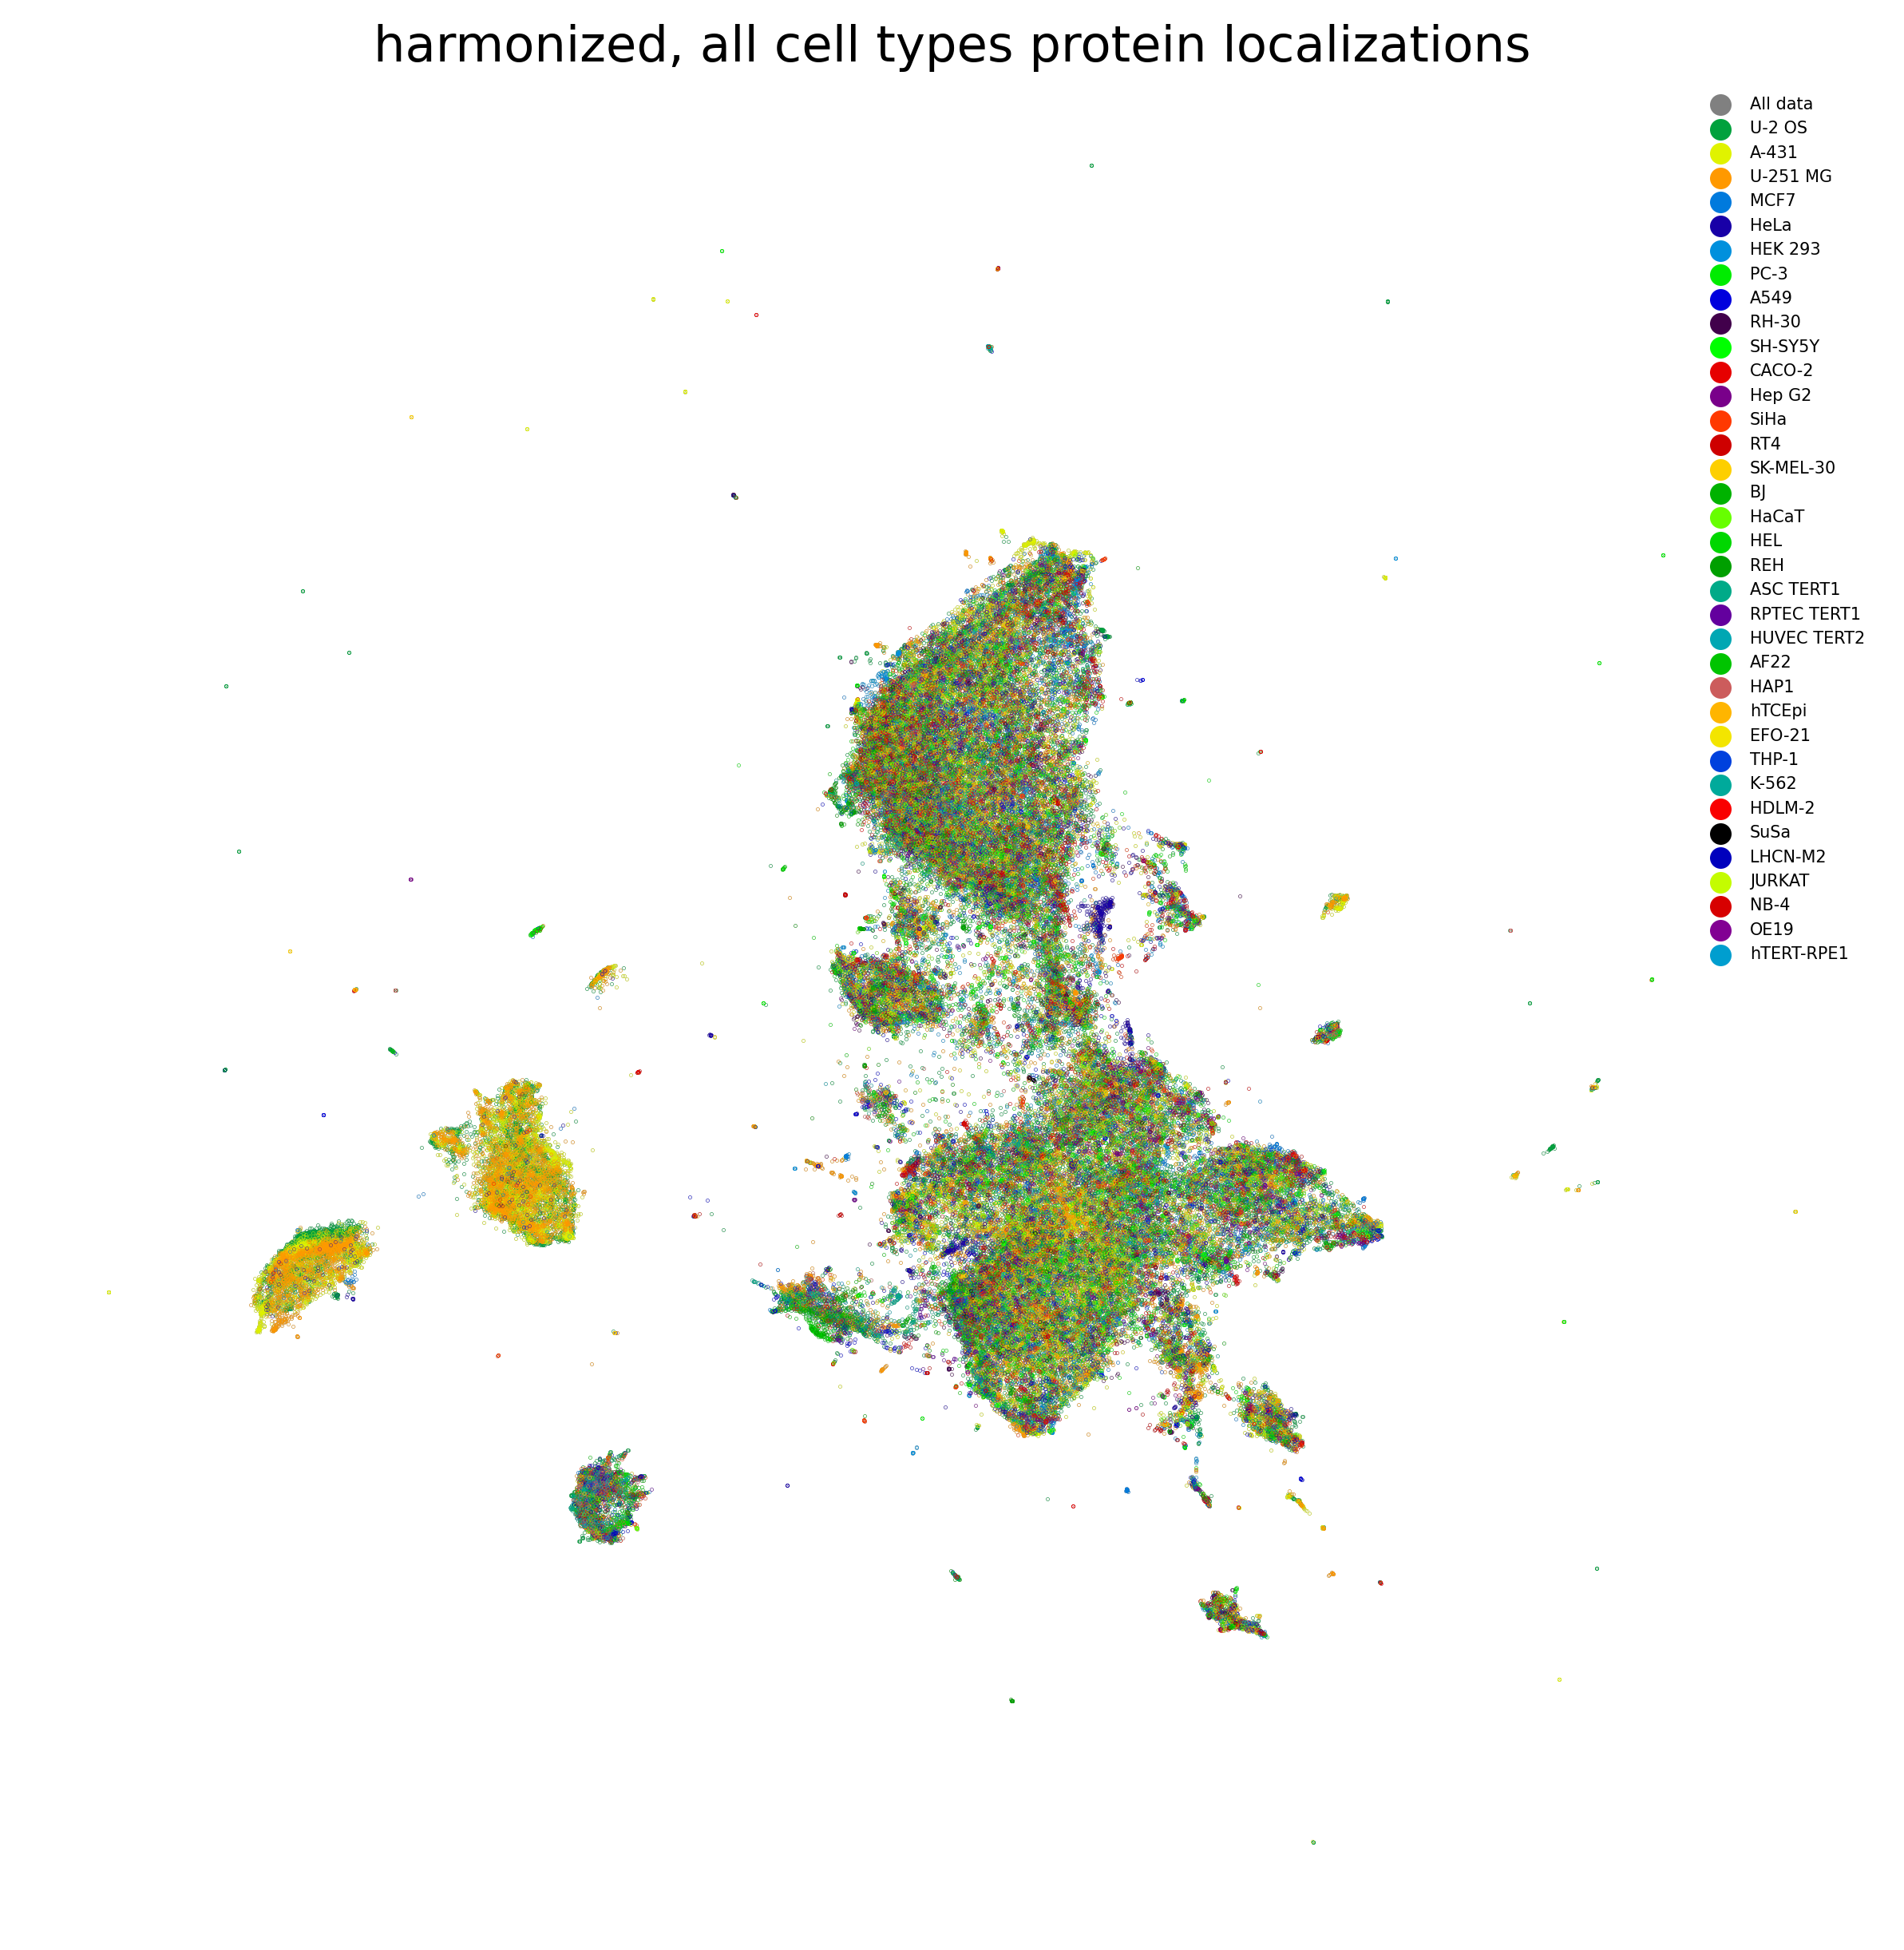

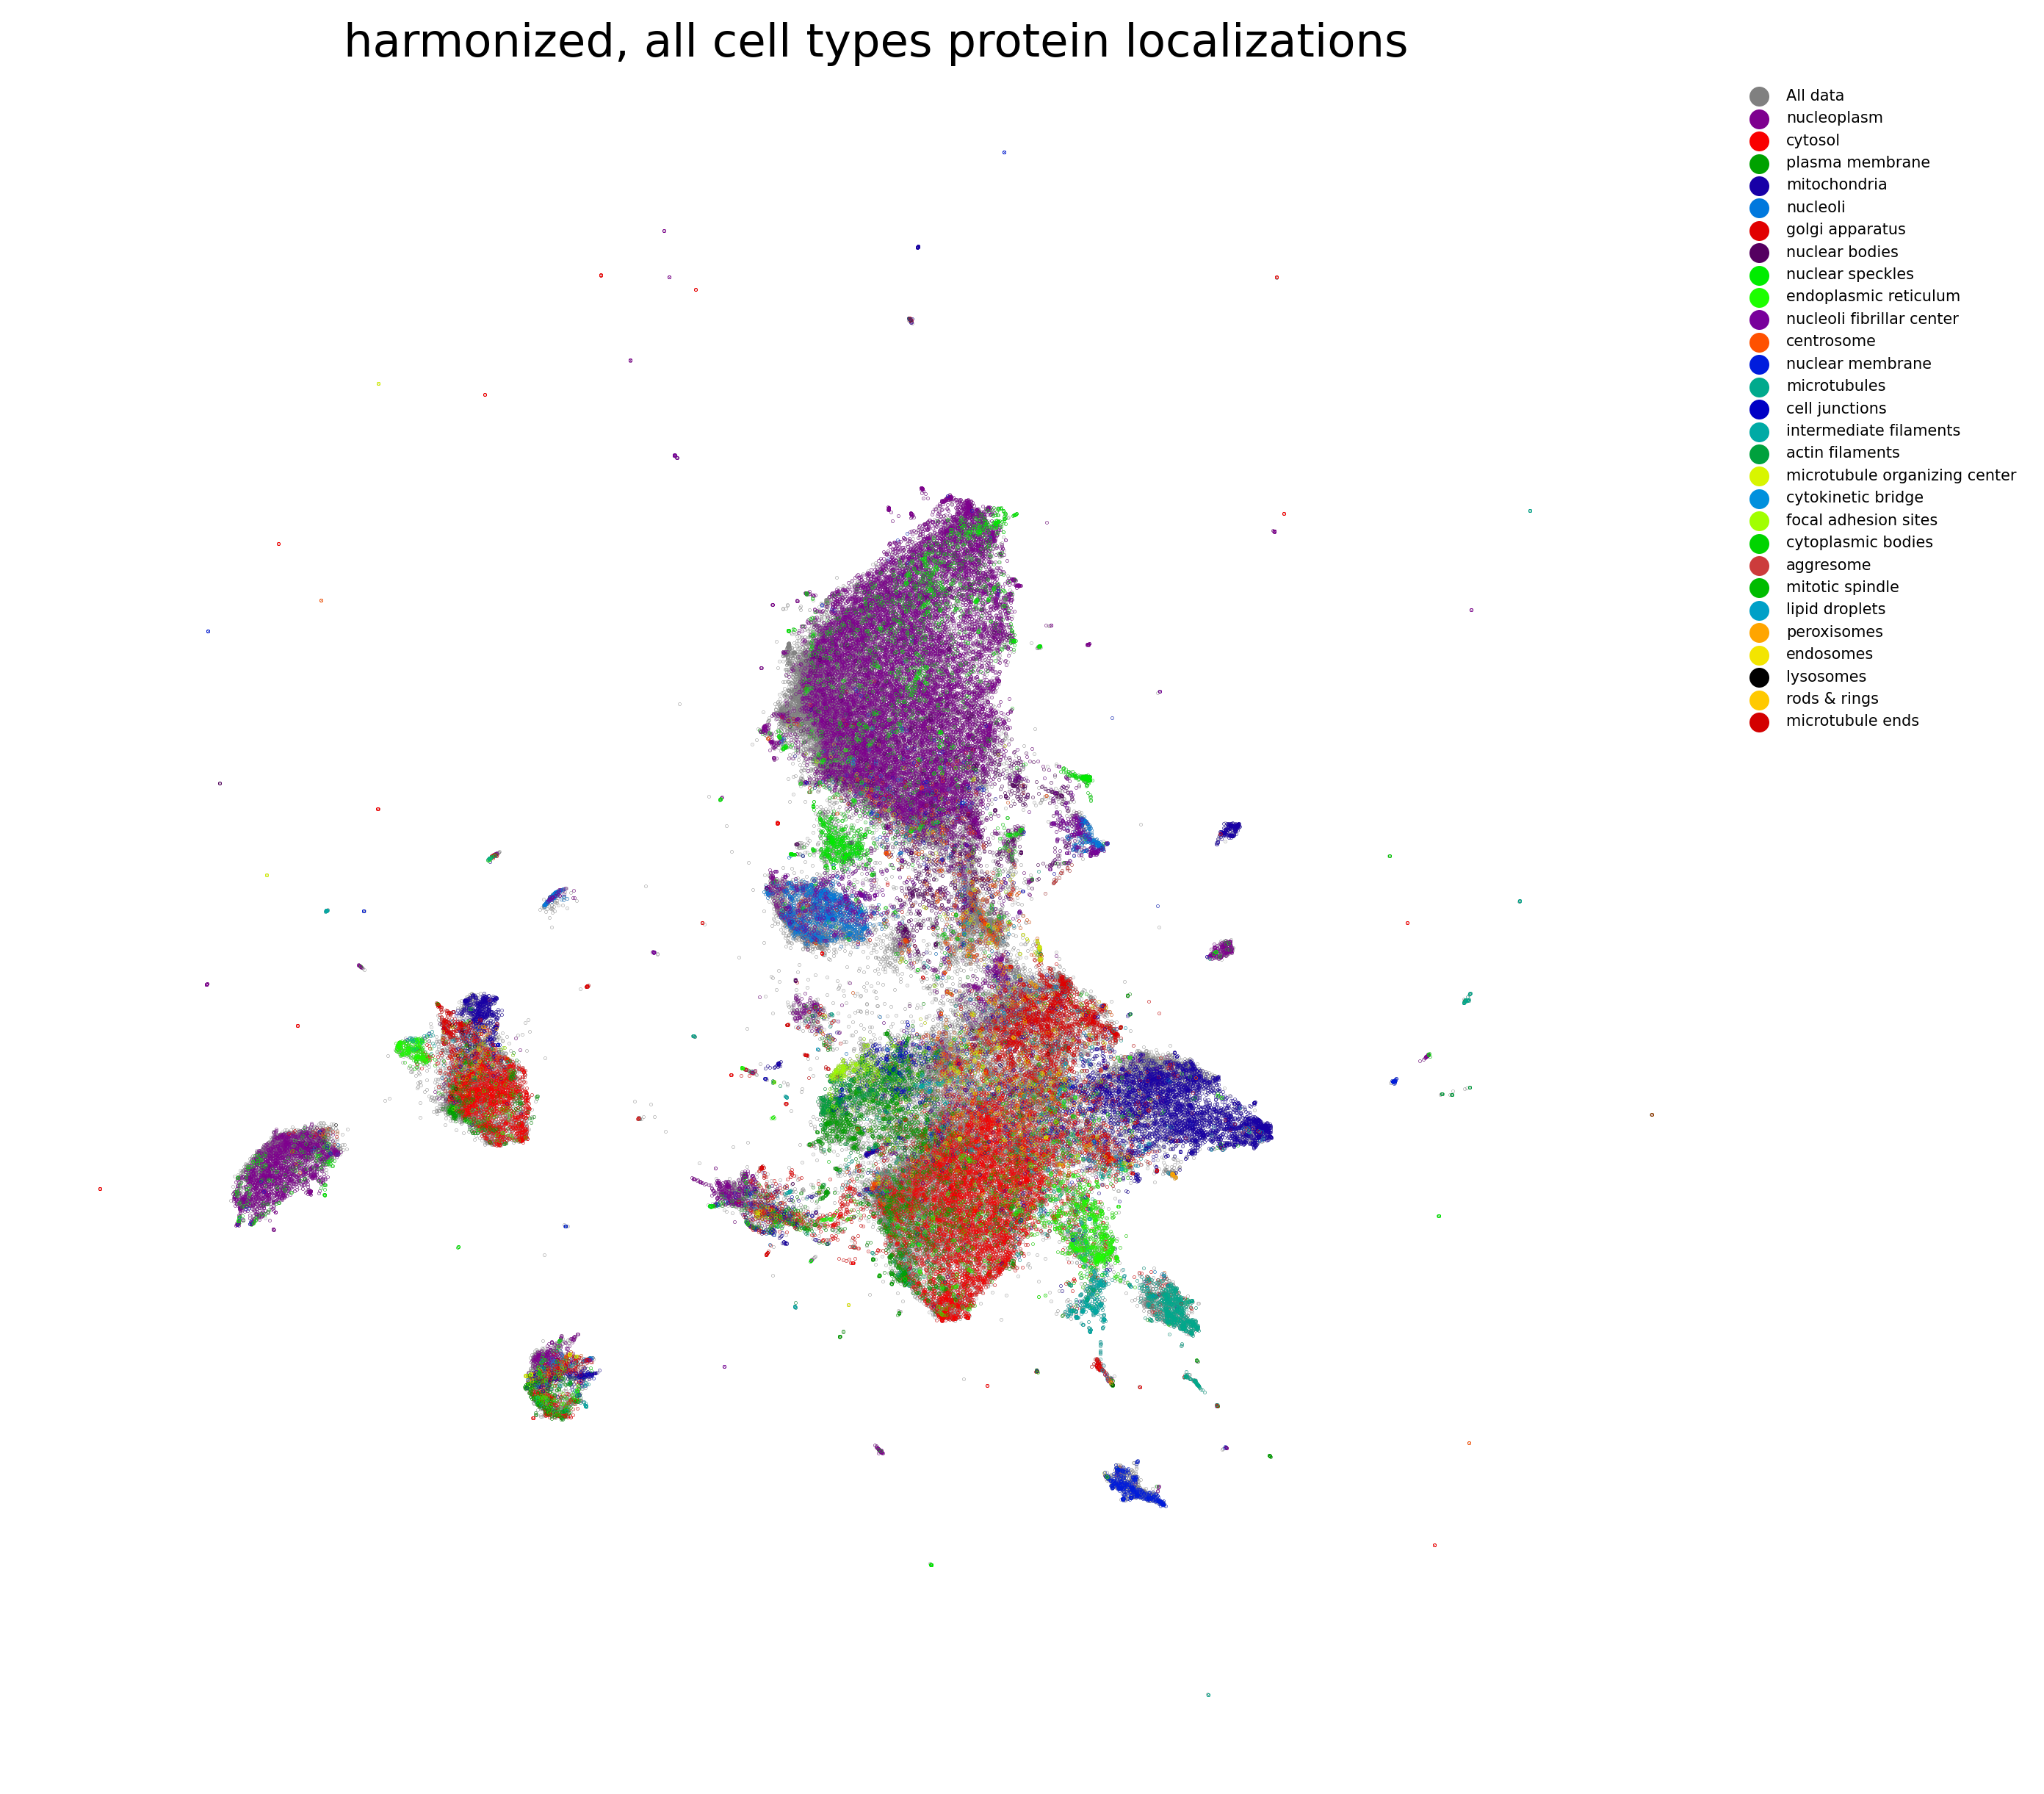

In [4]:
features, protein_localizations, cell_lines, IDs, df = torch.load('HPA_FOV_data/DINO_features_for_HPA_FOV.pth')
protein_labls = protein_to_num_full
harmonized_features = harmonize(torch.Tensor(features).numpy(), 
                                df,
                                batch_key = ['cell_type'], 
                                use_gpu=True,
                                random_state=42,
)
one_protein_indices = np.where(protein_localizations.sum(axis=1) == 1)[0]
features_to_fit = features[one_protein_indices]
features_to_extract = features
harmonized_features_to_fit = harmonized_features[one_protein_indices]
harmonized_features_to_extract = harmonized_features

umap_reducer, features_mean, features_std, harmonized_embedding, scaled_features = get_embeddings(torch.Tensor(harmonized_features_to_fit), torch.Tensor(harmonized_features_to_extract)) 
umap_reducer, features_mean, features_std, embedding, scaled_features = get_embeddings(torch.Tensor(features_to_fit), torch.Tensor(features_to_extract)) 

cell_color_indices = torch.load('HPA_FOV_data/whole_image_cell_color_indices.pth')
protein_color_indices = torch.load('HPA_FOV_data/whole_image_protein_color_indices.pth')

plot_UMAP(df, ['cell_type'], embedding,  f'all cell types', 'results/HPA_FOV/HPA_FOV_cell_types.pdf', cell_color_indices)
plot_UMAP(df, protein_labls, embedding,  f'all cell types', 'results/HPA_FOV/HPA_FOV_protein_localizations.pdf', protein_color_indices)
plot_UMAP(df, ['cell_type'], harmonized_embedding,  f'harmonized, all cell types protein localizations', 'results/HPA_FOV/HPA_FOV_cell_types_harmonized.pdf', cell_color_indices)
plot_UMAP(df, protein_labls, harmonized_embedding,  f'harmonized, all cell types protein localizations', 'results/HPA_FOV/HPA_FOV_protein_localizations_harmonized.pdf', protein_color_indices)


In [5]:
feature_files = [
    'HPA_FOV_data/bestfitting_features_for_HPA_FOV.pth',
    'HPA_FOV_data/DINO_features_for_HPA_FOV.pth',
    'HPA_FOV_data/DINO_features_for_HPA_FOV.pth',
]

labels = [
    'Bestfitting',
    'Trained DINO',
    'Trained DINO,\nharmonized',
             ]

hpa_model_labels = labels
hpa_mi_matrices = []
factor_gaps_per_method = []
code_bins = [25]
factor_bins = [25]
for code_bin, factor_bin in zip(code_bins, factor_bins):
    for feature_file, label in zip(feature_files, labels):
        features, protein_localizations, cell_lines, IDs, df = torch.load(feature_file)    
        try:
            protein_localizations = torch.stack(protein_localizations)
        except:
            pass
        protein_localizations = torch.Tensor(protein_localizations)

        one_protein_indices = np.where(protein_localizations.sum(axis=1) == 1)[0]
        website_indices = np.where(df.ID.str.contains('_'))[0]
        website_features = features[website_indices,:]
        website_df = df.iloc[website_indices].reset_index()
        website_df['plate'] = website_df.ID.str.split('_', expand=True)[0].values
        website_df['well'] = website_df.ID.str.split('_', expand=True)[1].values
        website_proteins = protein_localizations[website_indices]
        cell_mat, cell_labels = get_col_matrix(df, ['cell_type'])    
        website_cell = cell_mat[website_indices]
        one_protein_indices = np.where(website_proteins.sum(axis=1) == 1)[0]
        if 'harmonized' in label:
            website_features = harmonize(torch.Tensor(website_features).numpy(), 
                                            website_df,
                                            batch_key = ['cell_type'], 
                                            use_gpu=True,
                                            random_state=42,
            )        
        
        website_features -= website_features.min(axis=0)[0]
        website_features /= website_features.max(axis=0)[0]

        factors = np.stack((np.argmax(website_proteins[one_protein_indices], axis=1).numpy(),
                        np.argmax(website_cell[one_protein_indices], axis=1),
                        website_df['well'].values[one_protein_indices].astype(int))).T
        codes = torch.Tensor(website_features[one_protein_indices])

        whole_HPA_protein_MI = []
        whole_HPA_cell_MI = []
        whole_HPA_well_MI = []

        for i in tqdm(range(website_features.shape[1])):
            protein_mi = mutual_info(codes[:,i].numpy(), factors[:,0], code_bin, factor_bin)
            whole_HPA_protein_MI.append(protein_mi)
            cell_mi = mutual_info(codes[:,i].numpy(), factors[:,1], code_bin, factor_bin)
            whole_HPA_cell_MI.append(cell_mi)    
            well_mi = mutual_info(codes[:,i].numpy(), factors[:,2], code_bin, factor_bin)
            whole_HPA_well_MI.append(well_mi)      
        mi_matrix = np.stack((whole_HPA_protein_MI, whole_HPA_cell_MI, whole_HPA_well_MI))
    #     dcimig_score, mi_matrix = dcimig(factors, codes)
        highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][0,:], range(mi_matrix.shape[1])))).T
        second_highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][1,:], range(mi_matrix.shape[1])))).T
        gap = mi_matrix[highest_factor_mask[0,:],:].diagonal() - mi_matrix[second_highest_factor_mask[0,:],:].diagonal()
        factor_indices = [np.where(mi_matrix[i,:] >= np.max(mi_matrix, axis=0))[0] for i in range(factors.shape[1])]
        factor_gaps = [gap[f].max() if len(f) > 0 else 0 for f in factor_indices]
        factor_gaps_per_method.append(factor_gaps)
        hpa_mi_matrices.append(mi_matrix)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:15<00:00, 49.78it/s]


Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:15<00:00, 50.50it/s]


### Plot Kaggle results

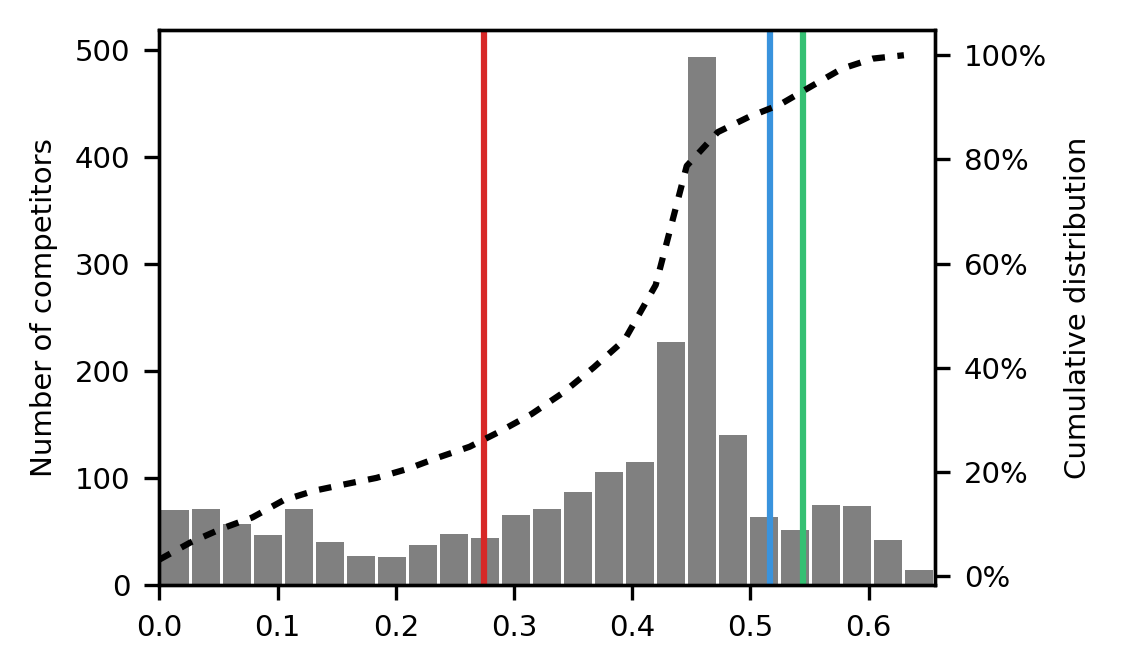

In [6]:
# os.chdir('Dino4Cells_analysis/')
whole_image_leaderboard = pd.read_csv('HPA_FOV_data/human-protein-atlas-image-classification-publicleaderboard.csv')
font = {'size'   : 7}
matplotlib.rc('font', **font)

fig, axis = plt.subplots(1,1,figsize=(2.5 * 1.5,1.5 * 1.5), dpi=300)

values = plt.hist(whole_image_leaderboard.Score, bins=25, label='Frequency', rwidth=0.9, color='grey')
cumulative = np.cumsum(values[0])
cumulative /= cumulative.max()
cumulative *= 100

DINO = 0.51687
Kaggle =  0.54423
pretrained = 0.27497

lw = 1.5
plt.axvline(x=DINO, color='#3993dd', label='DINO', linewidth=lw)
plt.axvline(x=Kaggle, color='#35c073', label='Kaggle', linewidth=lw)
plt.axvline(x=pretrained, color='#d72827', label='Pretrained', linewidth=lw)
plt.axis([whole_image_leaderboard.Score.min(), whole_image_leaderboard.Score.max(), 0, np.max(values[0]) + 25])
ax2 = axis.twinx()
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.plot(values[1][:-1], cumulative, color='black', dashes=[2], label='Cumulative', linewidth=lw)
plt.xlabel('Performance on test')
axis.set_ylabel('Number of competitors')
axis.set_yticks([0, 100, 200, 300, 400, 500])
ax2.set_ylabel('Cumulative distribution')
plt.tight_layout()
plt.savefig('results/HPA_FOV/HPA_FOV_Kaggle.pdf')

### Plot Cell Type classification

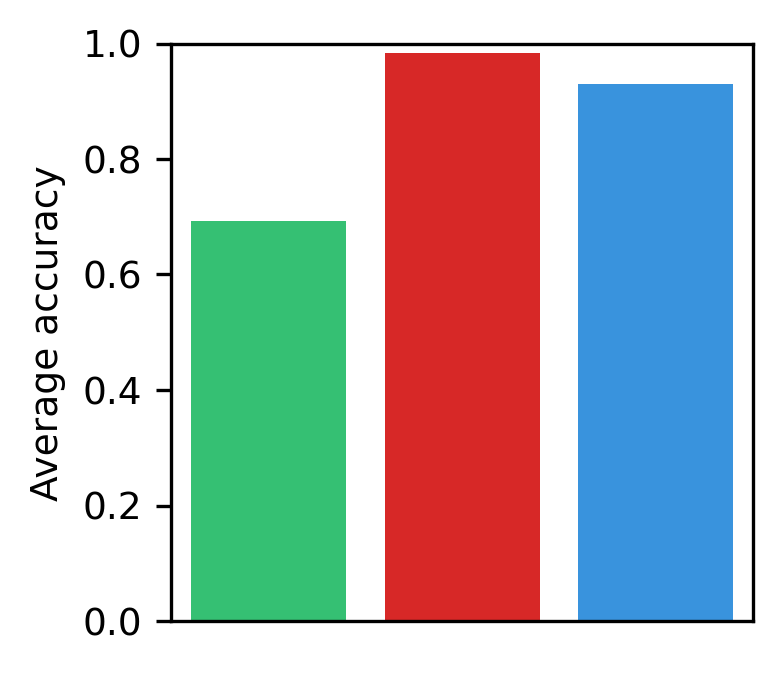

In [7]:
cells_DINO =  0.93
cells_Bestfitting = 0.6920088266191581
cells_Pretrained = 0.9834303297769443

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
font = {'size'   : 9}
matplotlib.rc('font', **font)
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch

fig, axis = plt.subplots(1,1,figsize=(2.5,2.5), dpi=300)
plt.bar(x=[0], height=[cells_Bestfitting], color='#35c073')
plt.bar(x=[1], height=[cells_Pretrained], color='#d72827')
plt.bar(x=[2], height=[cells_DINO], color='#3993dd')
plt.ylabel('Average accuracy')
plt.xticks([])
plt.axis([-0.5, 2.5, 0, 1])
plt.savefig('results/HPA_FOV/HPA_FOV_Cell_type.pdf')

0.7354135008935471


cell line / RNASeq mantel test: MantelResult(0.45711951820390506, 0.0001, 10.873677237386946)
protein CC knn, top-1: 0.37142857142857144
[0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0]


protein hierarchy mantel test: MantelResult(0.5293464805047168, 0.0001, 6.220214276334516)


0.5293464805047168

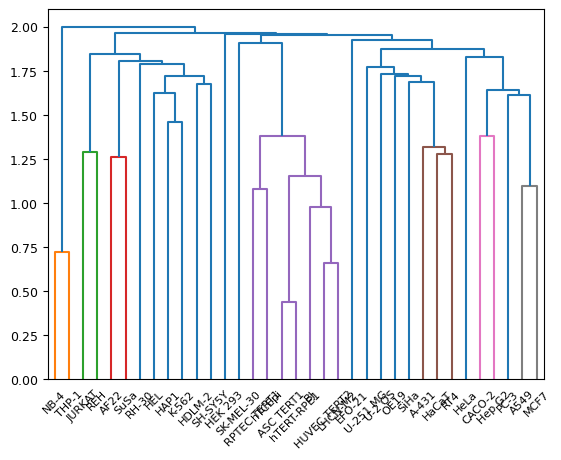

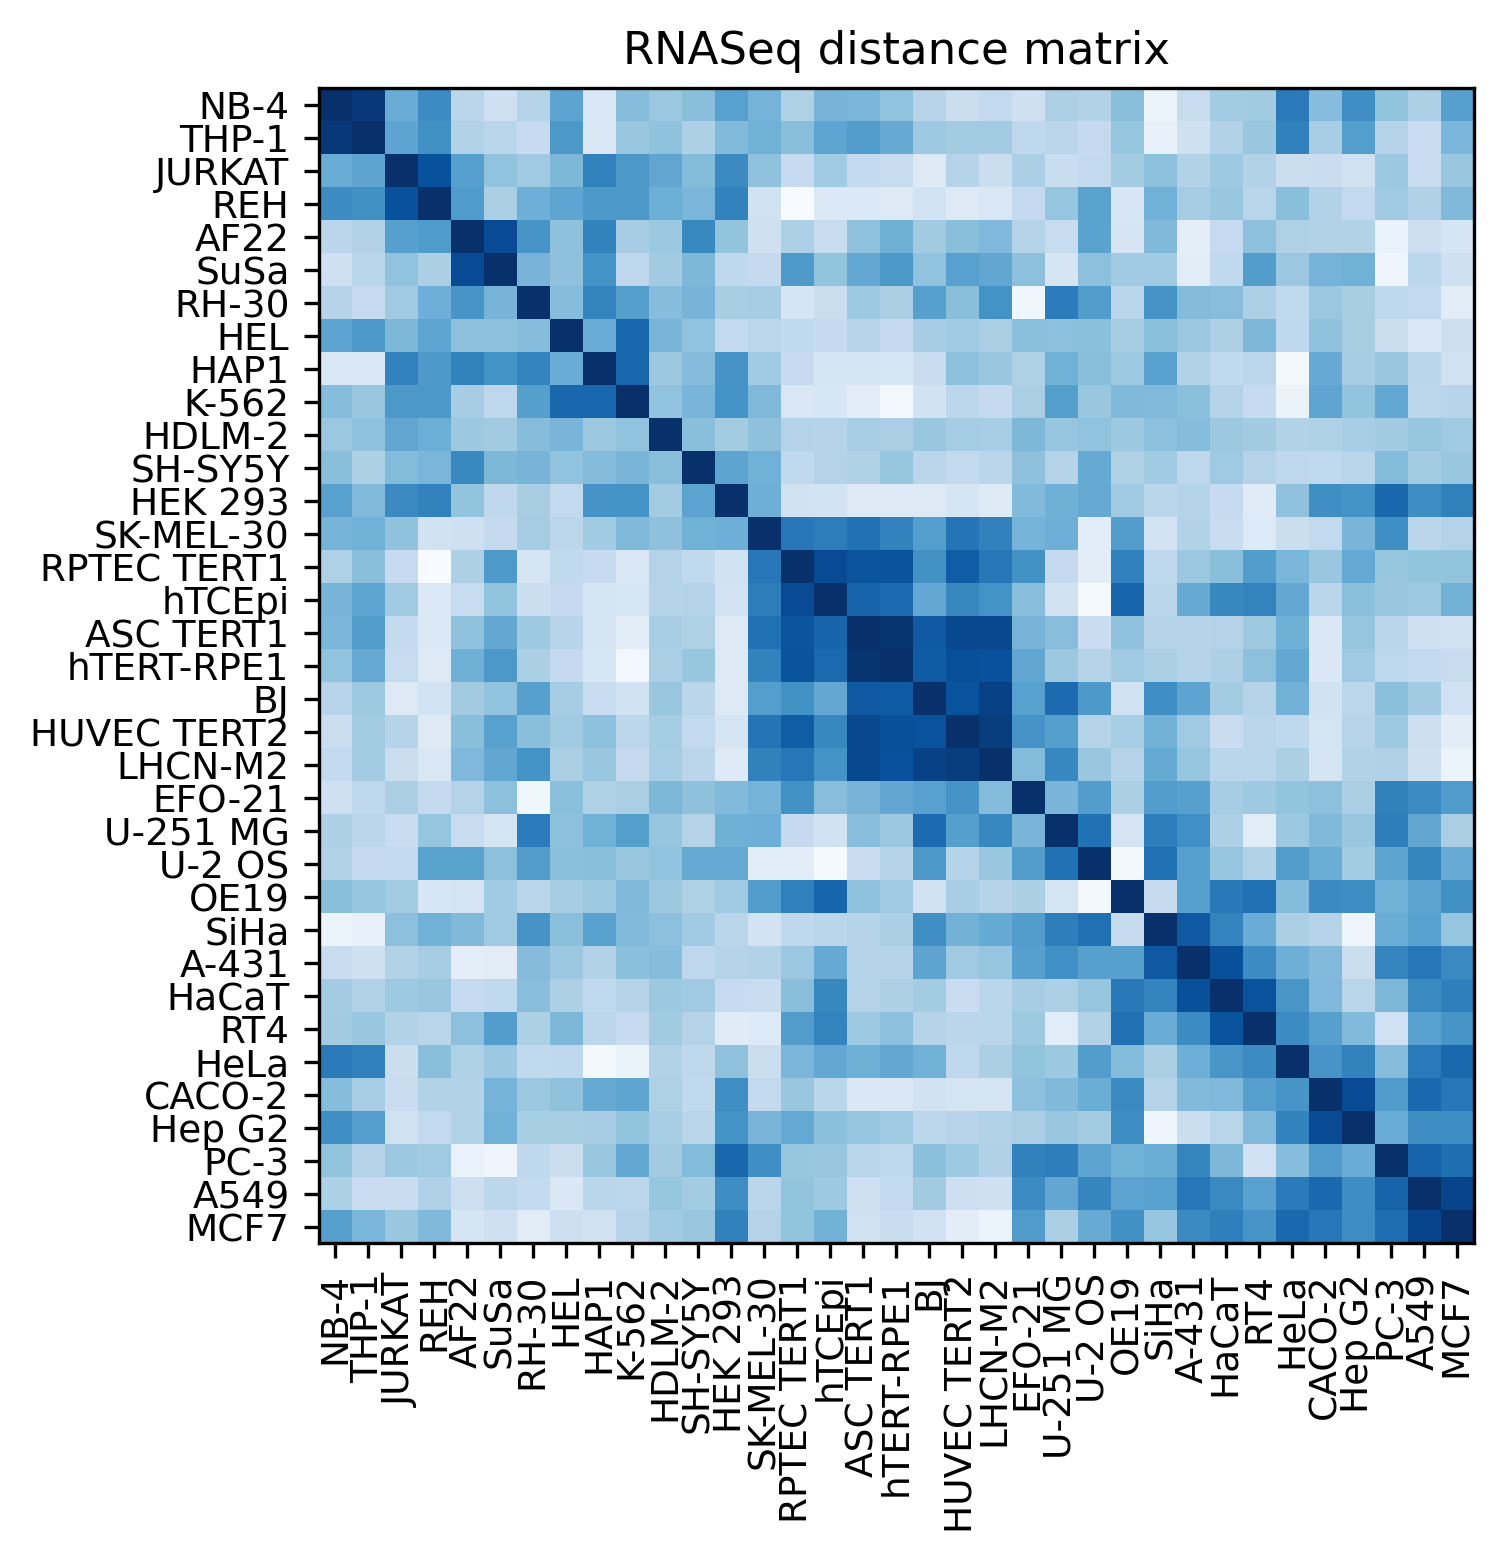

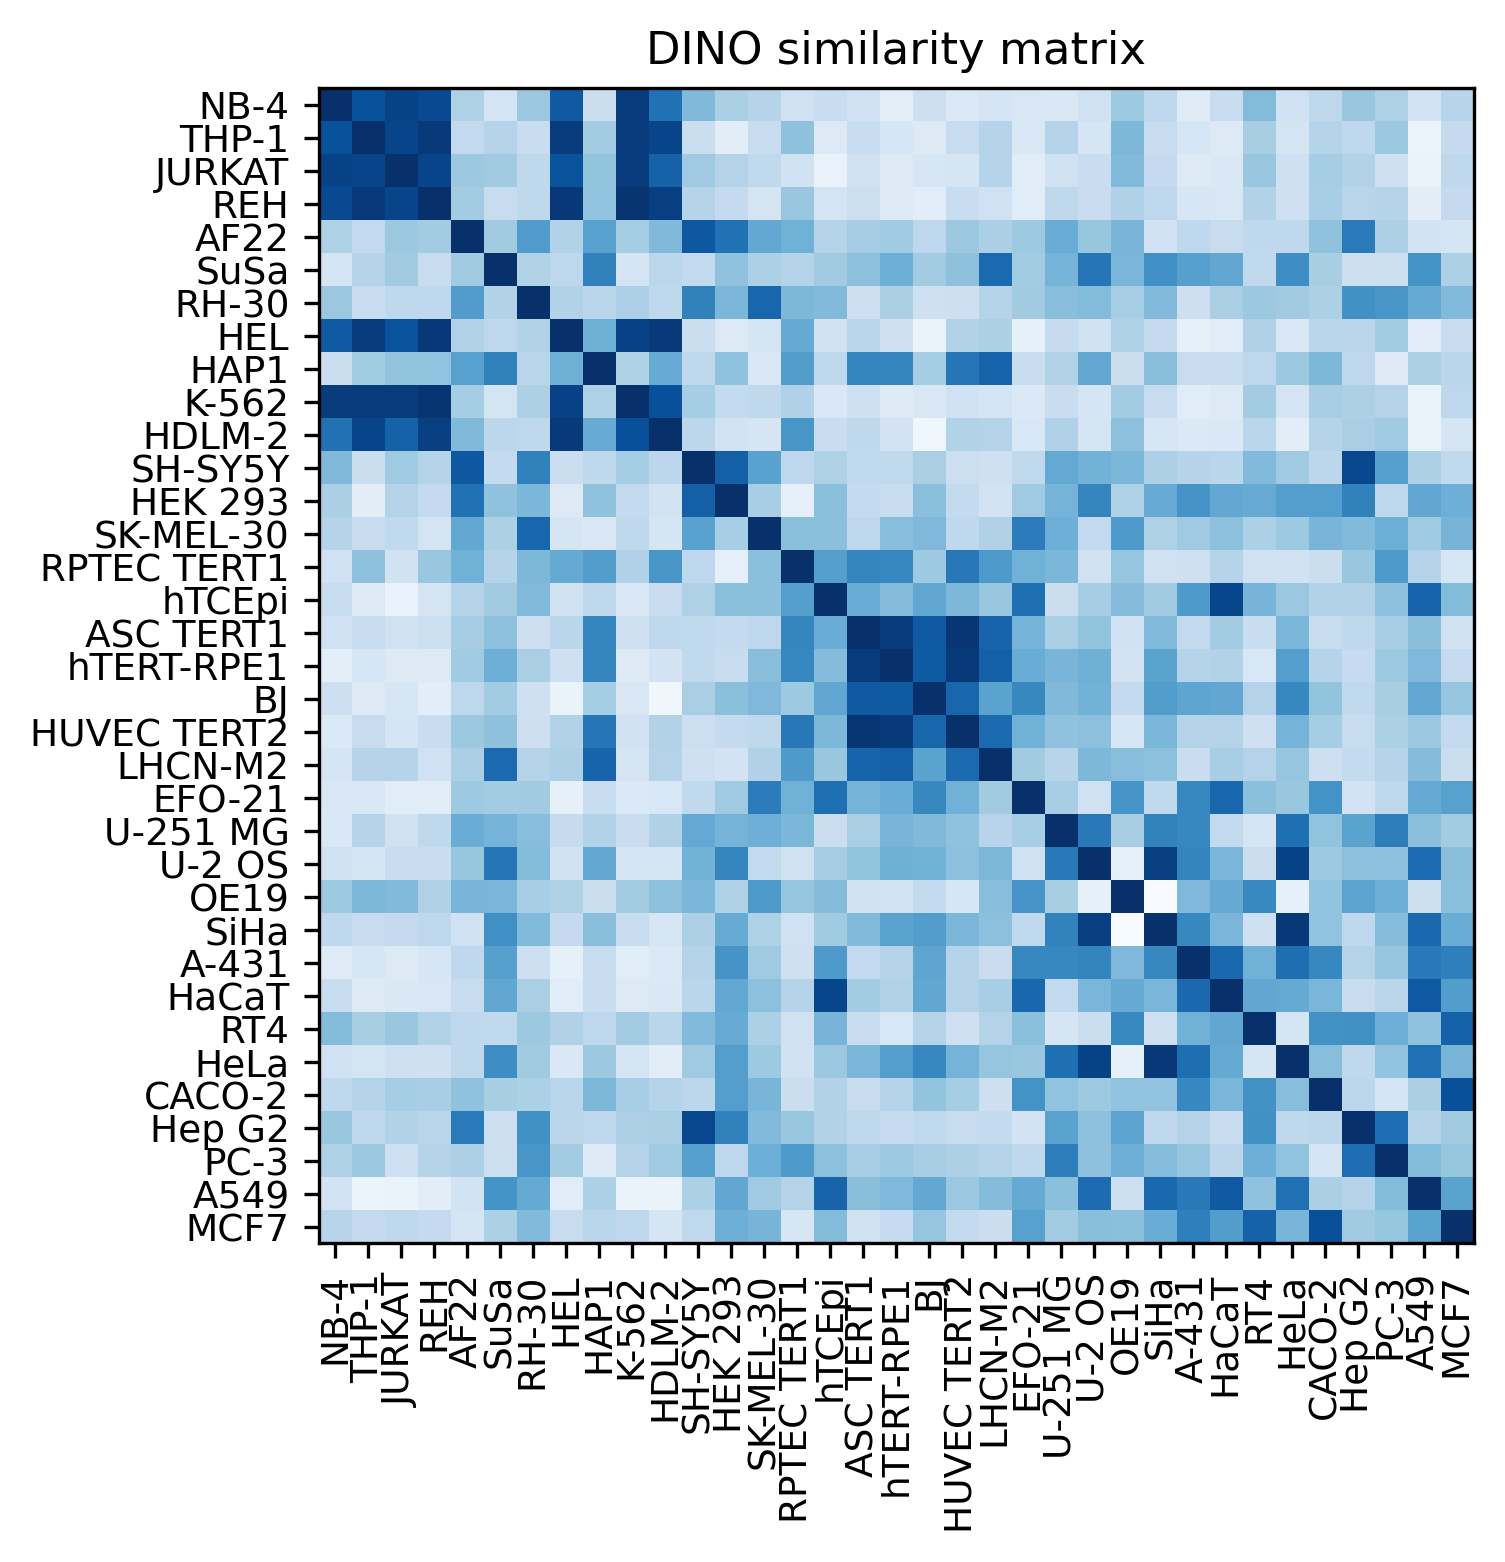

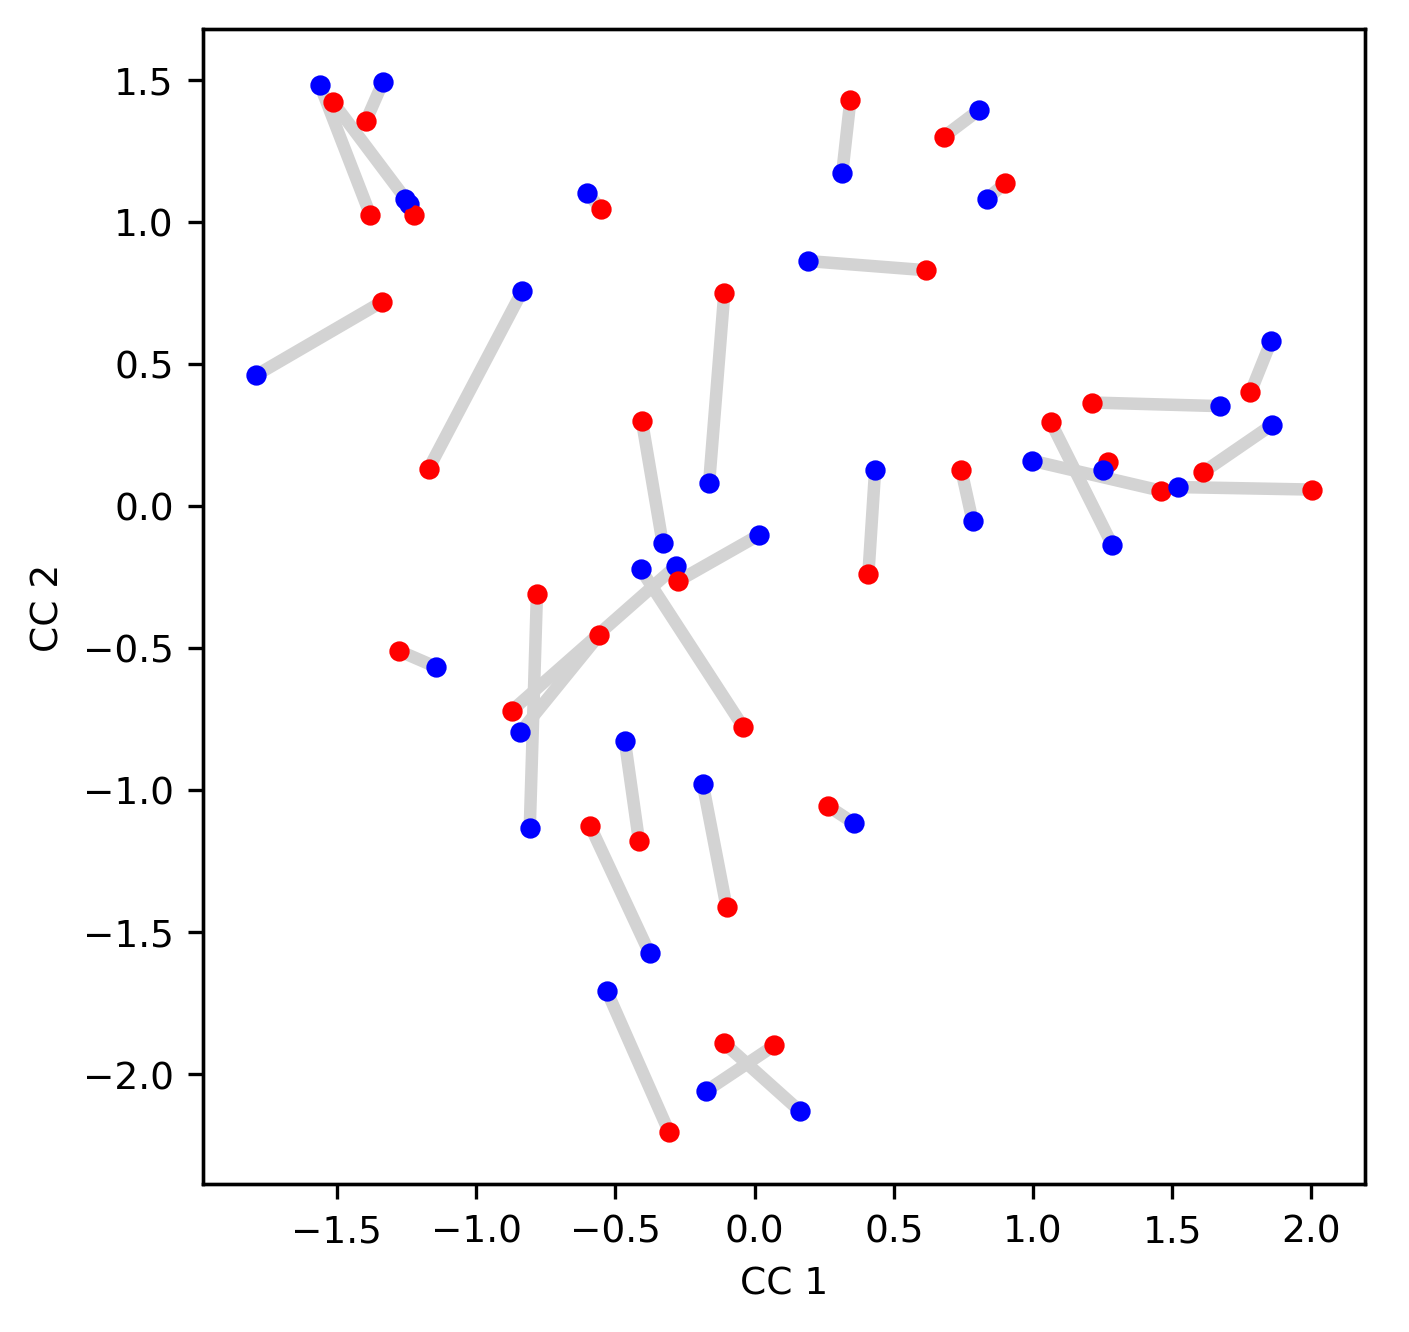

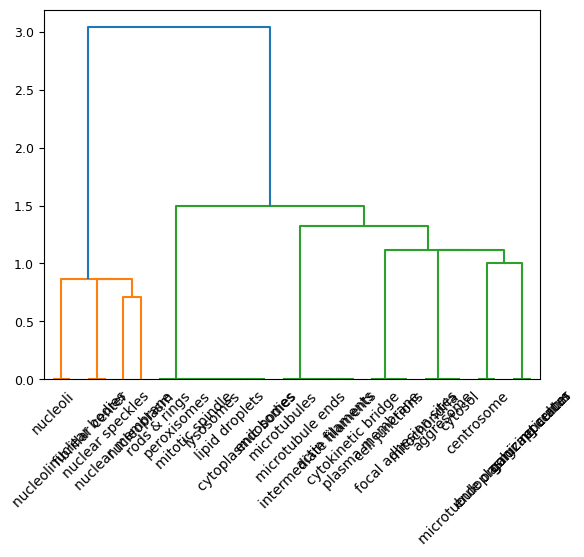

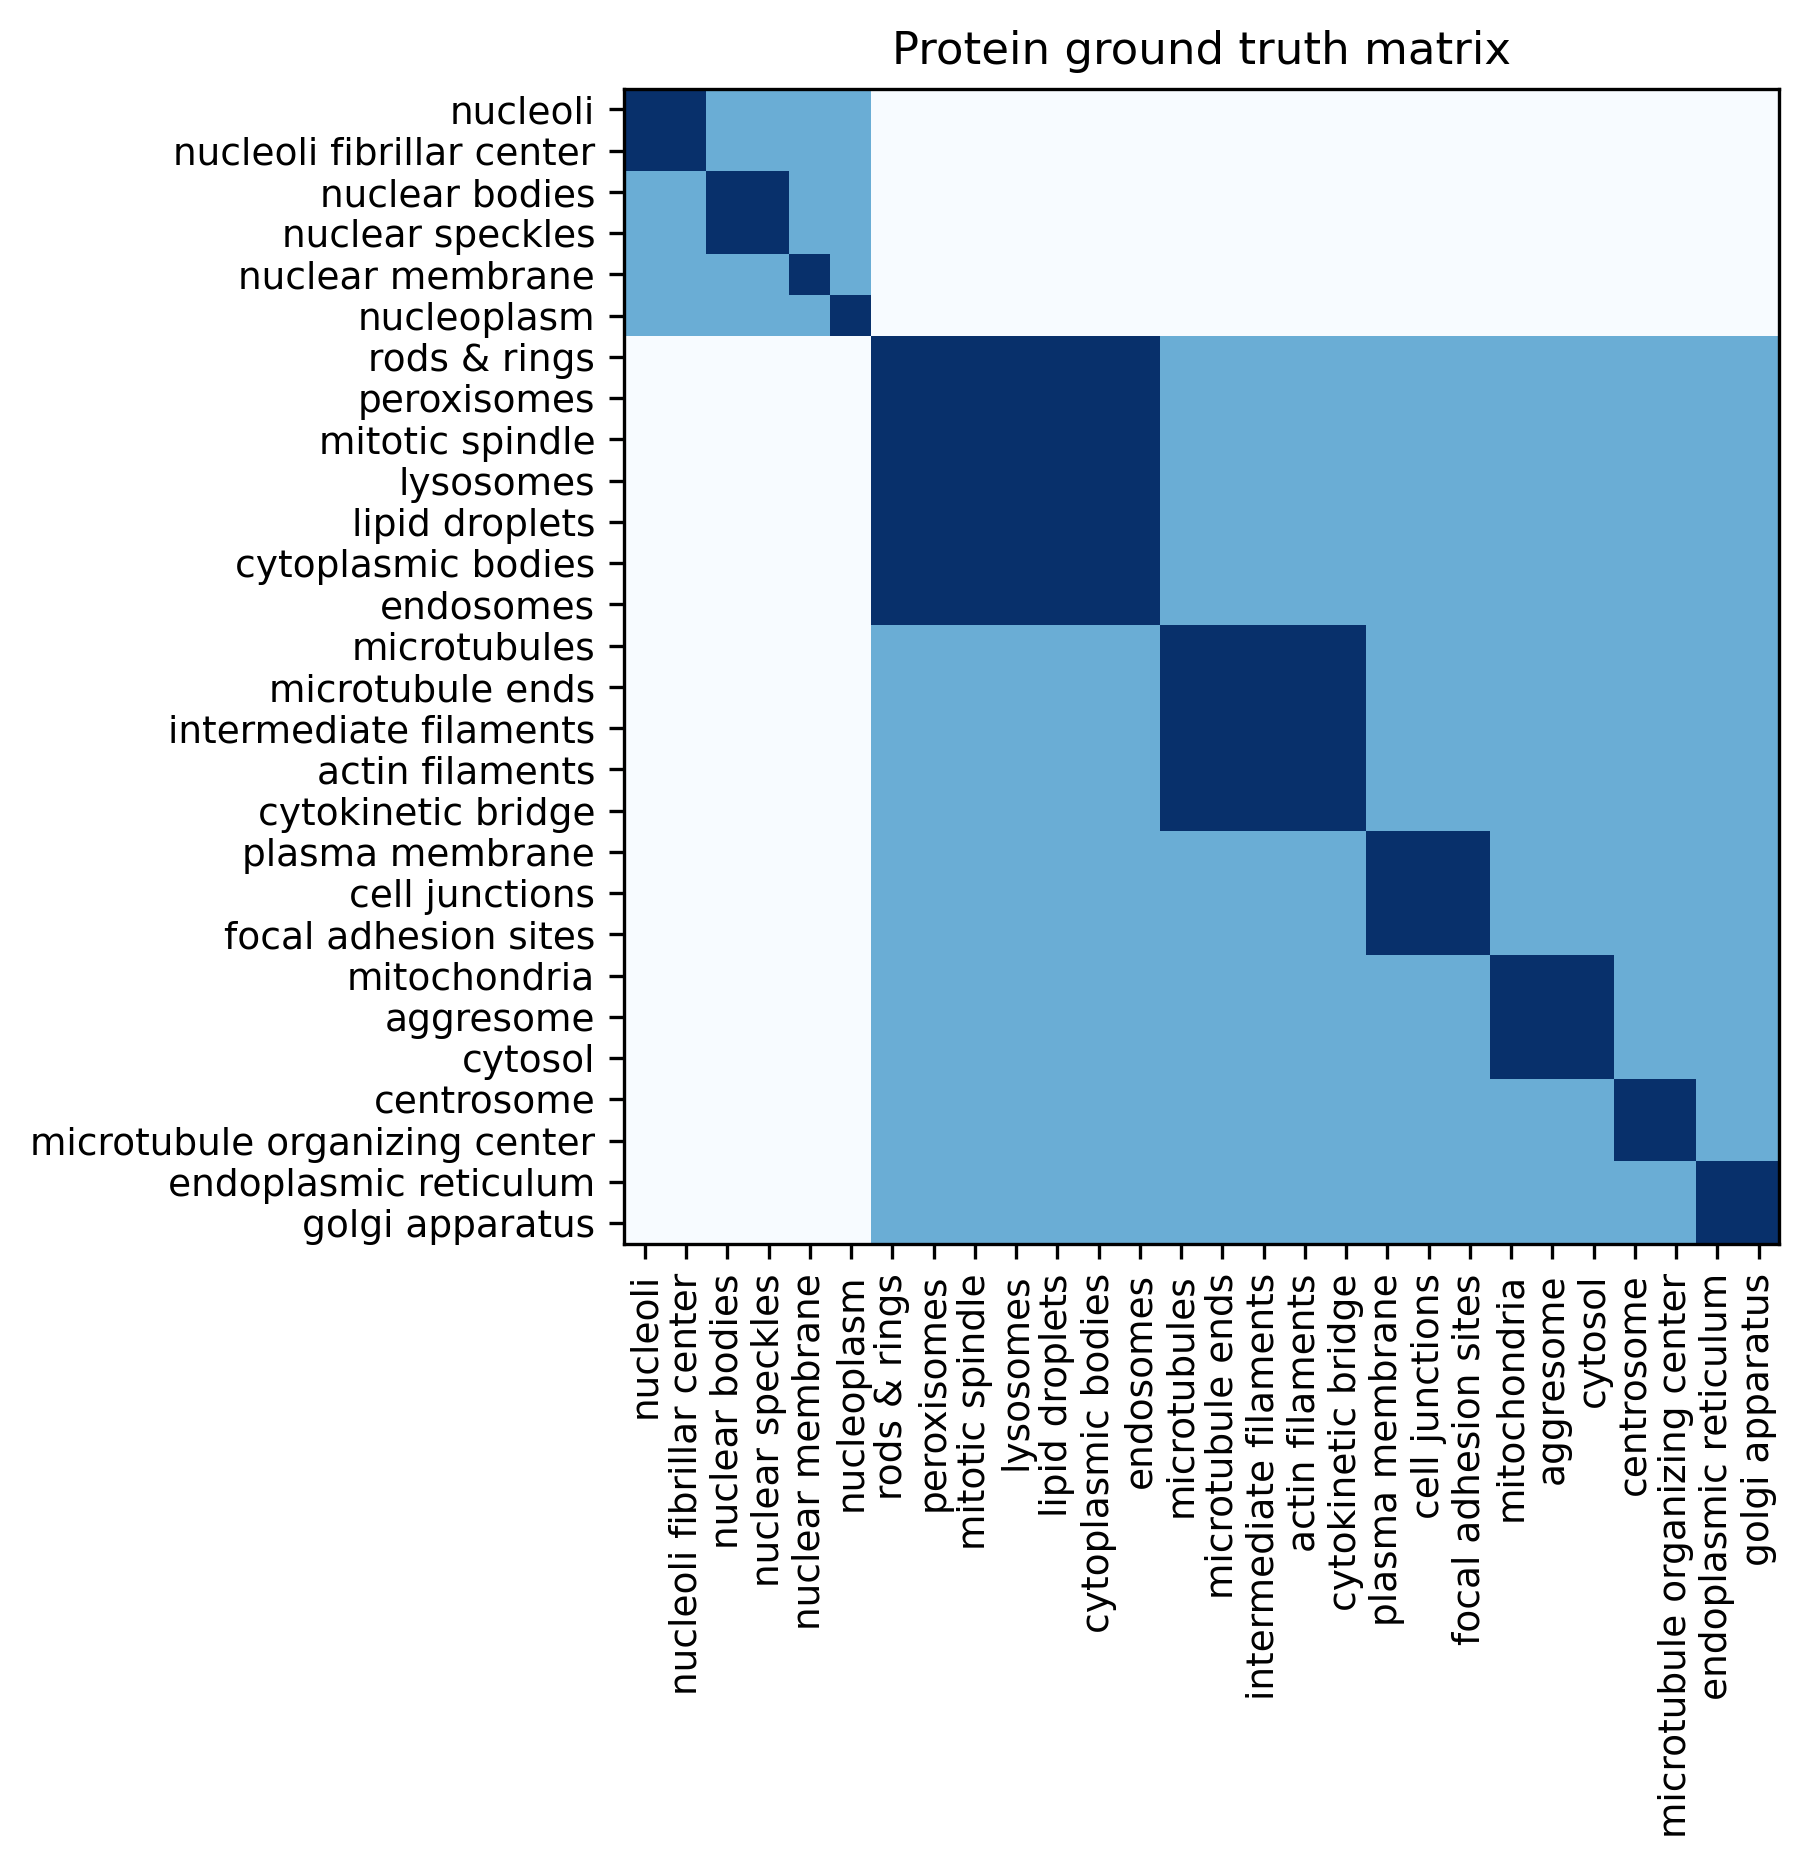

<Figure size 640x480 with 0 Axes>

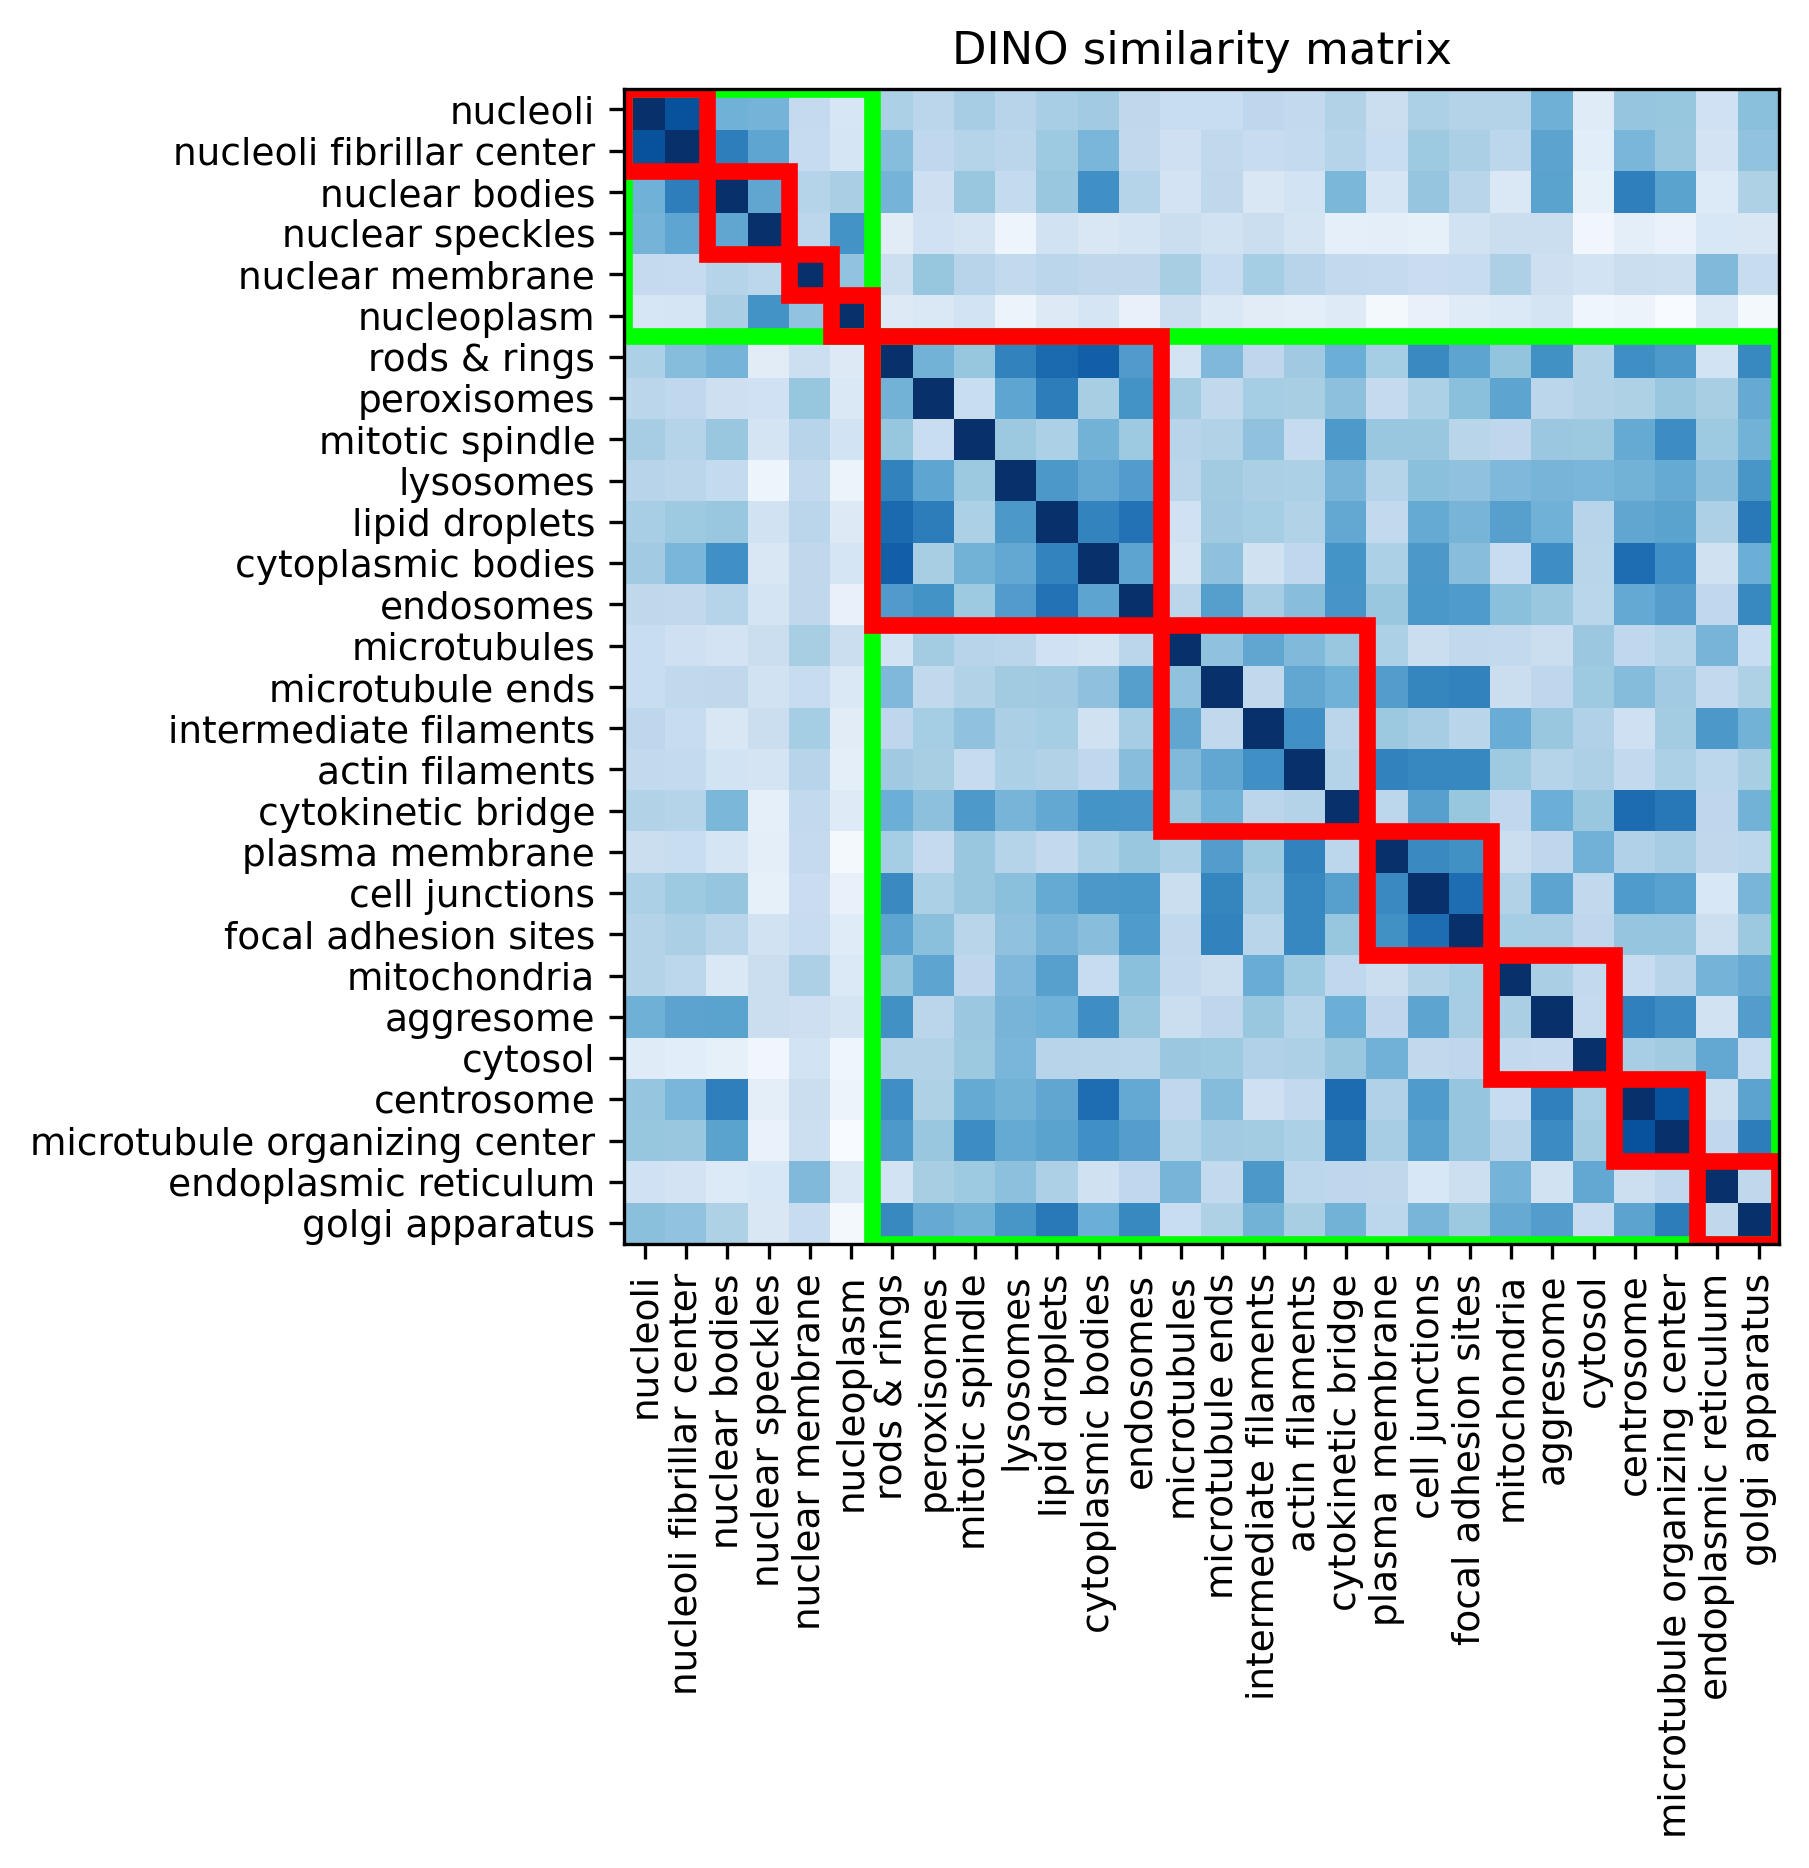

In [8]:
path_to_rna = 'HPA_FOV_data/rna_cellline.tsv'
rna = pd.read_csv(path_to_rna, delimiter="\t")
from matplotlib import cm
cmap = cm.nipy_spectral

create_cell_comparison(features, protein_localizations, cell_lines, IDs, df, rna, 'results/HPA_FOV/')
create_protein_hierarchy(features, protein_localizations, cell_lines, IDs, df, 'results/HPA_FOV/')